In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 禁止显示警告
warnings.filterwarnings("ignore")

# 读取CSV文件，跳过前两行
data = pd.read_csv('traffic_data.csv', skiprows=3)

# 删除列名前的空格
data.columns = data.columns.str.strip()

# 合并"Local Date"和"Local Time"列为一个日期时间列
data['datetime'] = pd.to_datetime(data['Local Date'] + ' ' + data['Local Time'])

# 更改列名
new_columns = {'Total Carriageway Flow': 'traffic_flow'}
data = data.rename(columns=new_columns)

# 保留指定的两列
data = data[['datetime', 'traffic_flow']]

# 将日期/时间列设置为数据集的索引
data.set_index('datetime', inplace=True)

# 使用最小值填充缺失值
data = data.fillna(data.min())

# 将数据集按每小时重新采样
data_resampled = data['traffic_flow'].resample('H').mean()

# 划分训练集和测试集
train_data = data_resampled[:'2023-01-15']
test_data = data_resampled['2023-01-16':]


In [2]:
# 设置参数范围
p_range = range(0, 3)  # AR阶数范围
d_range = range(0, 2)  # 差分阶数范围
q_range = range(0, 3)  # MA阶数范围
P_range = range(0, 3)  # 季节性AR阶数范围
D_range = range(0, 2)  # 季节性差分阶数范围
Q_range = range(0, 3)  # 季节性MA阶数范围
S = 24  # 季节周期

# 初始化最佳参数和最小RMSE
best_rmse = float('inf')
best_params = None

# 网格搜索
for p, d, q, P, D, Q in itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range):
    try:
        # 创建SARIMA模型
        model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))

        # 拟合SARIMA模型
        model_fit = model.fit(disp=False)

        # 进行交通流量预测
        predictions = model_fit.get_prediction(start=test_data.index[0], end=test_data.index[-1])

        # 提取预测值
        predicted_mean = predictions.predicted_mean

        # 计算RMSE
        mse = mean_squared_error(test_data, predicted_mean)
        rmse = np.sqrt(mse)

        # 更新最佳参数和最小RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (p, d, q, P, D, Q)
    except:
        continue

# 输出最佳参数和最小RMSE
print("Best SARIMA parameters: ", best_params)
print("Best RMSE: ", best_rmse)


Best SARIMA parameters:  (0, 0, 0, 2, 1, 2)
Best RMSE:  124.18423380198807


In [3]:
# 使用最佳参数重新训练模型
model = SARIMAX(train_data, order=best_params[:3], seasonal_order=best_params[3:] + (S,)).fit(disp=False)

# 进行交通流量预测
predictions = model.predict(start=test_data.index[0], end=test_data.index[-1])


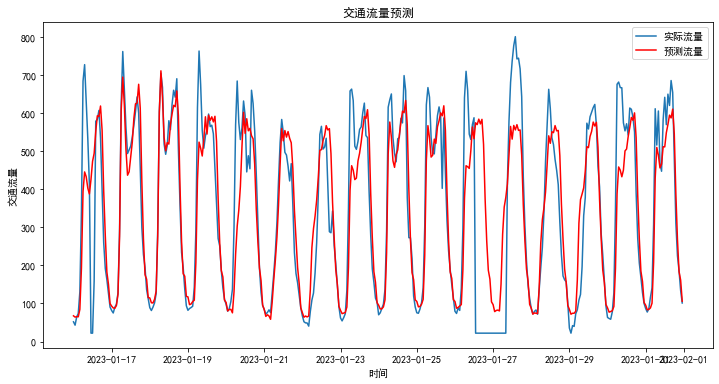

In [4]:
# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'SimHei'
plt.plot(test_data, label='实际流量')
plt.plot(predictions, color='red', label='预测流量')
plt.xlabel('时间')
plt.ylabel('交通流量')
plt.title('交通流量预测')
plt.legend()
plt.show()
